# **Analisis Sentimen Twitter**

# **1. Import Library**

In [16]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
import tensorflow as tf

from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from deep_translator import GoogleTranslator
from textblob import TextBlob
import time
import re

[nltk_data] Downloading package stopwords to C:\Users\Nettaanell
[nltk_data]     D\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **2. Add Dataset & Preprocessing**

Dari hasil scrapping pada file Scrapping.csv yang berisi data twitter, diimport dan diolah agar dapat menghilangkan simbol/karakter sehingga teks yang diambil merupakan teks inti yang berbobot terhadap opini. Pada hal ini juga dilakukan Translater ke dalam bahasa inggris agar dapat menggunakan TextBlob dimana pada library ini akan menghitung bobot nilai pada suatu data.

In [5]:
df = pd.read_csv("Scrapping.csv", sep=';')
df = df[['full_text']] 
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df.head()

,full_text
0,@heathengangs Mulai membaikmi fashion sense mu...
1,@chiseiyuu @21of12 dia satria mahatir ver jemb...
2,@nativora @manukacaramel Udah di posting si sa...
3,knp sih dia demen bgt pake hoodie gaya satria ...
4,@deduys kembaran satria mahatir ditolak sp yg ...


In [ ]:
stop_words = set(stopwords.words('indonesian'))
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#\w+", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\d+", "", text)
    text = text.strip()
    text = " ".join([word for word in text.split() if word not in stop_words])
    return text
df['clean_text'] = df['full_text'].apply(clean_text)

def translate_text(text):
    try:
        return GoogleTranslator(source='auto', target='en').translate(text)
    except Exception as e:
        print(f"Error: {e}")
        return text
translated = []

for i, row in df.iterrows():
    text = row['clean_text']
    if isinstance(text, str) and text.strip() != "":
        translated_text = translate_text(text)
    else:
        translated_text = ""
    translated.append(translated_text)
    if (i + 1) % 50 == 0:
        print(f"Translated {i+1} rows... sleeping 5 seconds.")
        time.sleep(5)

df['translated_text'] = translated
df.to_csv("Translated_Scrapping.csv", index=False)
print("Terjemahan selesai! Dataset disimpan sebagai 'Translated_Scrapping.csv'.")


Translated 50 rows... sleeping 5 seconds.
Translated 100 rows... sleeping 5 seconds.
Translated 150 rows... sleeping 5 seconds.
Translated 200 rows... sleeping 5 seconds.
Translated 250 rows... sleeping 5 seconds.
Translated 300 rows... sleeping 5 seconds.
Translated 350 rows... sleeping 5 seconds.
Translated 400 rows... sleeping 5 seconds.
Translated 450 rows... sleeping 5 seconds.
Translated 500 rows... sleeping 5 seconds.
Translated 550 rows... sleeping 5 seconds.
Translated 600 rows... sleeping 5 seconds.
Translated 650 rows... sleeping 5 seconds.
Translated 700 rows... sleeping 5 seconds.
Translated 750 rows... sleeping 5 seconds.
Translated 800 rows... sleeping 5 seconds.
Translated 850 rows... sleeping 5 seconds.
Translated 900 rows... sleeping 5 seconds.
Translated 950 rows... sleeping 5 seconds.
Translated 1000 rows... sleeping 5 seconds.
Translated 1050 rows... sleeping 5 seconds.
Translated 1100 rows... sleeping 5 seconds.
Translated 1150 rows... sleeping 5 seconds.
Translat

# **3. Labeling Data**

In [5]:
df = pd.read_csv("Translated_Scrapping.csv")
def get_sentiment(text):
    if isinstance(text, str) and text.strip() != "":
        analysis = TextBlob(text)
        polarity = analysis.sentiment.polarity
        if polarity > 0:
            return "positive"
        elif polarity < 0:
            return "negative"
        else:
            return "neutral"
    else:
        return "neutral"

df['label'] = df['translated_text'].apply(get_sentiment)
df['translated_text'] = df['translated_text'].fillna("")
print(df.shape)
df.head()

(3152, 4)


,full_text,clean_text,translated_text,label
0,@heathengangs Mulai membaikmi fashion sense mu...,membaikmi fashion sense mu mmg nda berkiblat s...,Improve your fashion sense mmg mmg and the rib...,neutral
1,@chiseiyuu @21of12 dia satria mahatir ver jemb...,satria mahatir ver jember cin,Satria Mahatir Ver Jember Cin,neutral
2,@nativora @manukacaramel Udah di posting si sa...,udah posting si satria mahatir,Already posted the Satria Mahatir,neutral
3,knp sih dia demen bgt pake hoodie gaya satria ...,knp sih demen bgt pake hoodie gaya satria mahatir,why is it really like using the hoodie style o...,positive
4,@deduys kembaran satria mahatir ditolak sp yg ...,kembaran satria mahatir ditolak sp yg ga kaget...,Kembatan Satria Mahatir was rejected SP who wa...,negative


# **A. LTSM : Tokenizer + pad_sequences**

## **4. Feature Extraction**

In [6]:
MAX_NUM_WORDS = 10000
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 100

df['clean_text'] = df['clean_text'].astype(str)
df = df[df['clean_text'].str.strip() != '']

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(df['clean_text'])
sequences = tokenizer.texts_to_sequences(df['clean_text'])
word_index = tokenizer.word_index

X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
y = pd.get_dummies(df['label']).values

## **5. Data Splitting**

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## **6. Pemodelan (Model Training)**

In [8]:
model = Sequential()
model.add(Embedding(input_dim=MAX_NUM_WORDS, output_dim=EMBEDDING_DIM,input_length=MAX_SEQUENCE_LENGTH))
model.add(Dropout(0.5))
model.add(LSTM(32, dropout=0.6, recurrent_dropout=0.4))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)
model.build(input_shape=(None, MAX_SEQUENCE_LENGTH))
model.summary()

C:\Users\Nettaanell D\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │        17,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,017,123 (3.88 MB)

 Trainable params: 1,017,123 (3.88 MB)

 Non-trainable params: 0 (0.00 B)

## **7. Evaluasi Model**

Epoch 1/11
20/20 ━━━━━━━━━━━━━━━━━━━━ 24s 473ms/step - accuracy: 0.6102 - loss: 0.9267 - val_accuracy: 0.7369 - val_loss: 0.6743
Epoch 2/11
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 508ms/step - accuracy: 0.7343 - loss: 0.6525 - val_accuracy: 0.7369 - val_loss: 0.5998
Epoch 3/11
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 363ms/step - accuracy: 0.7555 - loss: 0.5898 - val_accuracy: 0.7464 - val_loss: 0.5878
Epoch 4/11
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 545ms/step - accuracy: 0.7640 - loss: 0.5769 - val_accuracy: 0.7639 - val_loss: 0.5757
Epoch 5/11
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 506ms/step - accuracy: 0.7774 - loss: 0.5820 - val_accuracy: 0.7845 - val_loss: 0.5599
Epoch 6/11
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 511ms/step - accuracy: 0.8056 - loss: 0.5241 - val_accuracy: 0.7987 - val_loss: 0.5410
Epoch 7/11
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 429ms/step - accuracy: 0.8150 - loss: 0.5027 - val_accuracy: 0.8209 - val_loss: 0.5116
Epoch 8/11
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 586ms/step - accuracy: 0.8463 - loss: 0.4371 - val_accura

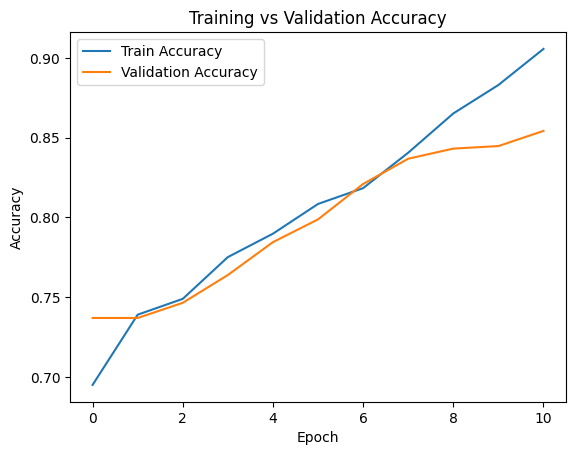

In [9]:
history = model.fit(X_train, y_train, epochs=11, batch_size=128, validation_data=(X_test, y_test), callbacks=[early_stop])
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

# **B. Logistic Regression + TF-IDF**

## **4. Data Splitting**

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df['translated_text'], df['label'], test_size=0.2, random_state=42)

## **5. Feature Extraction**

In [12]:
tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=10000)

## **6. Pemodelan (Model Training)**

In [14]:
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
lr = LogisticRegression(class_weight='balanced', max_iter=1000)
lr.fit(X_train_tfidf, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

## **7. Evaluasi Model**

In [15]:
y_pred = lr.predict(X_test_tfidf)
y_train_pred = lr.predict(X_train_tfidf)
print("Akurasi Training Set:", accuracy_score(y_train, y_train_pred))
print("Akurasi Validasi:", accuracy_score(y_test, y_pred))
print("Laporan Klasifikasi:\n", classification_report(y_test, y_pred))


Akurasi Training Set: 0.9845299484331614
Akurasi Validasi: 0.9080824088748018
Laporan Klasifikasi:
               precision    recall  f1-score   support

    negative       0.70      0.77      0.73        62
     neutral       0.96      0.94      0.95       471
    positive       0.81      0.85      0.83        98

    accuracy                           0.91       631
   macro avg       0.82      0.85      0.84       631
weighted avg       0.91      0.91      0.91       631



# **C. SVM + TF-IDF**

## **4. Feature Extraction & Data Splitting**

In [20]:
X = df['translated_text']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')  # Bisa coba unigram dan bigram
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

## **5. Pemodelan (Model Training)**

In [21]:
svm_model = SVC(kernel='linear')  # Linear kernel biasanya bagus untuk teks
svm_model.fit(X_train_tfidf, y_train)
y_pred = svm_model.predict(X_test_tfidf)

## **6. Evaluasi Model**

In [23]:
y_train_pred = svm_model.predict(X_train_tfidf)
y_test_pred = svm_model.predict(X_test_tfidf)

print(f"Akurasi pada Training Set: ", accuracy_score(y_train, y_train_pred))
print(f"Akurasi pada Testing Set: ", accuracy_score(y_test, y_test_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Akurasi pada Training Set:  0.9900833002776676
Akurasi pada Testing Set:  0.9239302694136292
Classification Report:
              precision    recall  f1-score   support

    negative       0.98      0.65      0.78        62
     neutral       0.92      1.00      0.96       471
    positive       0.95      0.74      0.83        98

    accuracy                           0.92       631
   macro avg       0.95      0.80      0.86       631
weighted avg       0.93      0.92      0.92       631

